In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv(r"C:\Users\moham\Desktop\ML project\train.csv")
test = pd.read_csv(r"C:\Users\moham\Desktop\ML project\test.csv")

In [3]:
def extract_title(name):
    if pd.isna(name):
        return "Unknown"
    parts = name.split(',')
    if len(parts) > 1:
        return parts[1].split('.')[0].strip()
    return "Unknown"


def preprocess(df):
    df = df.copy()

    # Extract Title
    df['Title'] = df['Name'].apply(extract_title)

    title_map = {
        'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs',
        'Lady': 'Rare', 'Countess': 'Rare', 'Capt': 'Rare', 'Col': 'Rare',
        'Don': 'Rare', 'Dr': 'Rare', 'Major': 'Rare', 'Rev': 'Rare',
        'Sir': 'Rare', 'Jonkheer': 'Rare', 'Dona': 'Rare'
    }
    df['Title'] = df['Title'].replace(title_map)

    # Family size features
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

    # Fill Embarked
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

    # Fill Fare
    if 'Fare' in df.columns:
        df['Fare'] = df['Fare'].fillna(df['Fare'].median())

    # Fill Age using median by Pclass & Sex
    age_median = df.groupby(['Pclass', 'Sex'])['Age'].transform('median')
    df['Age'] = df['Age'].fillna(age_median)
    df['Age'] = df['Age'].fillna(df['Age'].median())

    # Drop unused columns
    drop_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin']
    df = df.drop(columns=[c for c in drop_cols if c in df.columns])

    return df


train_proc = preprocess(train)
test_proc = preprocess(test)

In [4]:
X = train_proc.drop(columns=['Survived'])
y = train_proc['Survived']

# cast some columns to categorical
X['Pclass'] = X['Pclass'].astype(str)
test_proc['Pclass'] = test_proc['Pclass'].astype(str)

X['IsAlone'] = X['IsAlone'].astype(str)
test_proc['IsAlone'] = test_proc['IsAlone'].astype(str)


numeric_features = ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize']
categorical_features = ['Sex', 'Embarked', 'Pclass', 'Title', 'IsAlone']

In [5]:
num_transformer = SimpleImputer(strategy='median')
cat_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numeric_features),
        ('cat', cat_transformer, categorical_features)
    ]
)

In [6]:
model = make_pipeline(
    preprocessor,
    RandomForestClassifier(n_estimators=200, random_state=42)
)

In [7]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')

print("CV Scores:", cv_scores)
print("Mean accuracy:", cv_scores.mean())

CV Scores: [0.81005587 0.80337079 0.80337079 0.8258427  0.83146067]
Mean accuracy: 0.8148201619484026


In [8]:
model.fit(X, y)

train_preds = model.predict(X)
print("\nTraining accuracy:", accuracy_score(y, train_preds))
print("\nConfusion matrix:\n", confusion_matrix(y, train_preds))
print("\nClassification report:\n", classification_report(y, train_preds))


Training accuracy: 0.9831649831649831

Confusion matrix:
 [[545   4]
 [ 11 331]]

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       549
           1       0.99      0.97      0.98       342

    accuracy                           0.98       891
   macro avg       0.98      0.98      0.98       891
weighted avg       0.98      0.98      0.98       891



In [9]:
X_test = test_proc.copy()
test_preds = model.predict(X_test)

submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': test_preds
})

submission.to_csv("submission_titanic.csv", index=False)

print("\nSubmission saved as submission_titanic.csv")


Submission saved as submission_titanic.csv


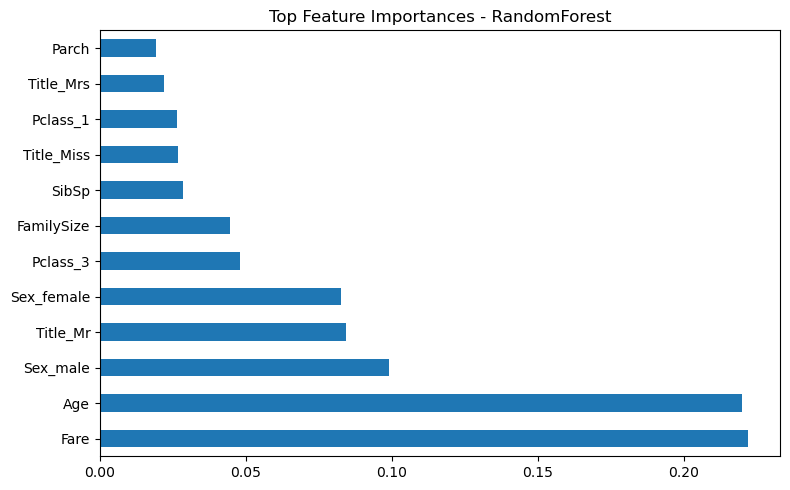

In [10]:
ohe = model.named_steps['columntransformer'].named_transformers_['cat'].named_steps['onehotencoder']
cat_names = list(ohe.get_feature_names_out(categorical_features))
feature_names = numeric_features + cat_names

importances = model.named_steps['randomforestclassifier'].feature_importances_
feat_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)

feat_series.head(12).plot(kind='barh', figsize=(8, 5))
plt.title("Top Feature Importances - RandomForest")
plt.tight_layout()
plt.show()

In [11]:
def predict_person(model,
                   Pclass,
                   Sex,
                   Age,
                   SibSp,
                   Parch,
                   Fare,
                   Embarked,
                   Name="Test Name"):
    """
    Predict survival for one passenger based on manual input
    """

    # Build a row exactly like the test/train data
    data = pd.DataFrame([{
        "Pclass": Pclass,
        "Sex": Sex,
        "Age": Age,
        "SibSp": SibSp,
        "Parch": Parch,
        "Fare": Fare,
        "Embarked": Embarked,
        "Name": Name,
        "Ticket": "0000",
        "Cabin": np.nan
    }])

    # Use same preprocessing as before
    data_proc = preprocess(data)

    # Fix types (same as training)
    data_proc["Pclass"] = data_proc["Pclass"].astype(str)
    data_proc["IsAlone"] = data_proc["IsAlone"].astype(str)

    pred = model.predict(data_proc)[0]

    return "Survived" if pred == 1 else "Did NOT Survive"


In [12]:
result = predict_person(
    model=model,
    Pclass=3,
    Sex="male",
    Age=22,
    SibSp=1,
    Parch=0,
    Fare=7.25,
    Embarked="S",
    Name="Mr. John Doe"
)

print(result)


Did NOT Survive


In [13]:
predict_person(
    model,
    Pclass=1,
    Sex="female",
    Age=28,
    SibSp=0,
    Parch=0,
    Fare=80,
    Embarked="C",
    Name="Mrs. Anna Smith"
)


'Survived'